<a href="https://colab.research.google.com/github/jonnythebard/tf2_workbook/blob/master/lstm_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense, SimpleRNN, Flatten, GRU, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.0.0


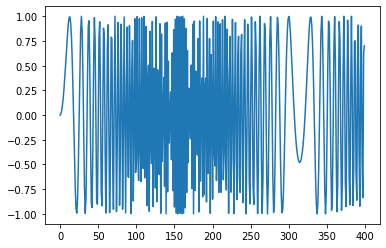

In [2]:
# create the data
# this data mean to be non linear
series = np.sin((0.1*np.arange(400))**2)

plt.plot(series)
plt.show()

In [3]:
# preprocess data to feed RNN model
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t + T]
  X.append(x)
  y = series[t + T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape:", X.shape, "Y.shape:", Y.shape)

X.shape: (390, 10) Y.shape: (390,)


In [0]:
# split the dataset
# in time series, train & test dataset shouldn't be split randomly
x_train = X[:-N//2]
y_train = Y[:-N//2]
x_test = X[-N//2:]
y_test = Y[-N//2:]

In [5]:
# let's try autoregressive linear model before LSTM
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.01))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [6]:
# train the RNN
r = model.fit(x_train, y_train, epochs=80, validation_data=(x_test, y_test))

Train on 195 samples, validate on 195 samples
Epoch 1/80
195/195 [==============================] - 1s 7ms/sample - loss: 1.2198 - val_loss: 1.0618
Epoch 2/80
195/195 [==============================] - 0s 196us/sample - loss: 1.0496 - val_loss: 0.9195
Epoch 3/80
195/195 [==============================] - 0s 180us/sample - loss: 0.9303 - val_loss: 0.8324
Epoch 4/80
195/195 [==============================] - 0s 169us/sample - loss: 0.8257 - val_loss: 0.7694
Epoch 5/80
195/195 [==============================] - 0s 170us/sample - loss: 0.7509 - val_loss: 0.7134
Epoch 6/80
195/195 [==============================] - 0s 168us/sample - loss: 0.6883 - val_loss: 0.6621
Epoch 7/80
195/195 [==============================] - 0s 200us/sample - loss: 0.6368 - val_loss: 0.6294
Epoch 8/80
195/195 [==============================] - 0s 239us/sample - loss: 0.6000 - val_loss: 0.6196
Epoch 9/80
195/195 [==============================] - 0s 200us/sample - loss: 0.5733 - val_loss: 0.6114
Epoch 10/80
195/195 

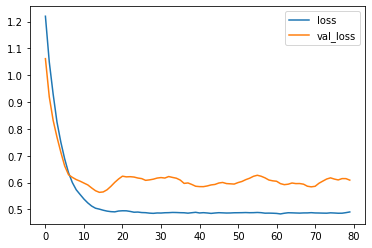

In [7]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

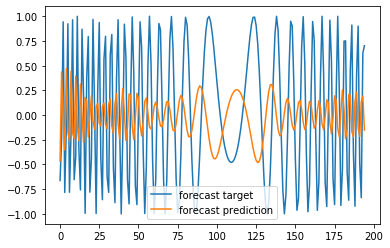

In [8]:
# One-step forecast using true targets
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(y_test):
  p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

plt.plot(y_test, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

# the predict is expected to be bad

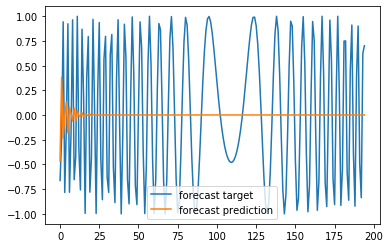

In [9]:
# Multi-step forecast
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(y_test):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(y_test, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# the predict is expected to be terrible

In [10]:
# Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D
x_train = X[:-N//2]
y_train = Y[:-N//2]
x_test = X[-N//2:]
y_test = Y[-N//2:]

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.05))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [11]:
# train the RNN
r = model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test))

Train on 195 samples, validate on 195 samples
Epoch 1/200
195/195 [==============================] - 5s 25ms/sample - loss: 0.5274 - val_loss: 0.5042
Epoch 2/200
195/195 [==============================] - 0s 277us/sample - loss: 0.4906 - val_loss: 0.5456
Epoch 3/200
195/195 [==============================] - 0s 261us/sample - loss: 0.4394 - val_loss: 0.6901
Epoch 4/200
195/195 [==============================] - 0s 324us/sample - loss: 0.4817 - val_loss: 0.4918
Epoch 5/200
195/195 [==============================] - 0s 356us/sample - loss: 0.3691 - val_loss: 0.3913
Epoch 6/200
195/195 [==============================] - 0s 294us/sample - loss: 0.2896 - val_loss: 0.3692
Epoch 7/200
195/195 [==============================] - 0s 303us/sample - loss: 0.2542 - val_loss: 0.2506
Epoch 8/200
195/195 [==============================] - 0s 292us/sample - loss: 0.1381 - val_loss: 0.1872
Epoch 9/200
195/195 [==============================] - 0s 300us/sample - loss: 0.0893 - val_loss: 0.1375
Epoch 10/2

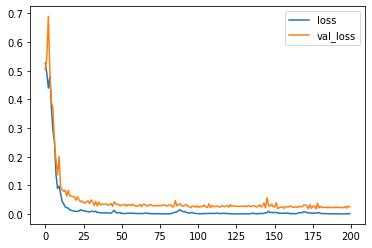

In [12]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


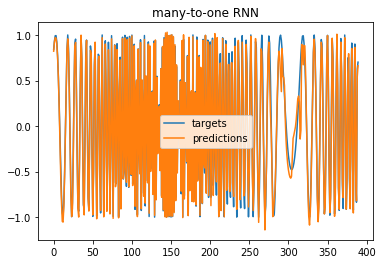

In [13]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

# the predict is expected to be a bit better than auto regression model

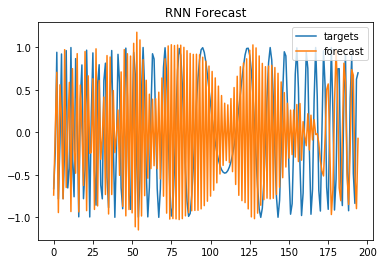

In [14]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()

# the prediction don't really make sense, at least i can see it tries to predict something